# Exercise 15: Power analyses

This  assignment is designed to give you practice with Monte Carlo methods to conduct power analyses via simulation. You won't need to load in any data for this homework. We will, however, be using parts of the homework from last week.

1. Simulating data 1/1
2. run_analysis function 2/2
3. repeat_analysis() function 3/3
4. Testing different sample sizes 2/2
5. Reflection 2/2

---
## 1. Simulating data (1 points)


Pull your `simulate_data()` function from your last homework and add it below.

As a reminder, this function simulates the relationship between age, word reading experience, and reading comprehension skill.

`c` is reading comprehension, and `x` is word reading experience.

In [ ]:
sample_size = 100 # How many children in data set?
age_lo = 80     # minimum age, in months
age_hi = 200    # maximum age, in months
beta_xa = 0.5   # amount by which experience changes for increase of one month in age
beta_x0 = -5    # amount of experience when age = 0 (not interpretable, since minimum age for this data is 80 months)
sd_x = 50       # standard dev of gaussian noise term, epsilon_x
beta_ca = 0.8   # amount that comprehension score improves for every increase of one unit in age
beta_cx = 3     # amount that comprehension score improves for every increase of one unit in reading experience
beta_c0 = 10    # comprehension score when reading experience is 0
sd_c = 85      # standard dev of gaussian noise term, epsilon_c

simulate_data <- function(sample_size, age_lo, age_hi, beta_xa,
                          beta_x0, sd_x, beta_ca, beta_cx, beta_c0, sd_c) {

      # generate age values uniformly distributed between age_lo and age_hi
      age <- runif(sample_size, min = age_lo, max = age_hi)

      # generate reading experience based on the model
      # x = β_xa * a + β_x0 + ε_x
      epsilon_x <- rnorm(sample_size, mean = 0, sd = sd_x)
      x <- beta_xa * age + beta_x0 + epsilon_x

      # generate comprehension experience based on the model
      # c = β_ca * a + β_cx * x + β_c0 + ε_c
      epsilon_c <- rnorm(sample_size, mean = 0, sd = sd_c)
      c <- beta_ca * age + beta_cx * x + beta_c0 + epsilon_c

      # dataframe with simulated variables
      data.frame(age = age, x = x, c = c)

}

dat <- simulate_data(sample_size, age_lo, age_hi, beta_xa, beta_x0, sd_x, beta_ca, beta_cx, beta_c0, sd_c)
head(dat)

,age,x,c
,<dbl>,<dbl>,<dbl>
1,90.31729,-7.056185,45.438372
2,193.67776,65.661790,338.151120
3,159.91528,-28.155507,5.663145
4,127.20180,17.313933,73.303405
5,107.00363,59.982356,270.852995
6,168.90098,78.393654,523.008825


---
## 2. `run_analysis()` function (2 pts)

Last week, we looked at whether word reading experience(`x`) mediated the relation between `age` and reading comprehension (`c`).

Now we're going to use our `simulate_data()` function to conduct a power analysis. The goal is to determine how many participants we would need in order to detect both the mediated and the direct effects in this data.

*Note: We're going to pretend for the sake of simplicity that we don't have any control over the ages of the children we get (so ages are generated using `runif(sample_size, age_lo, age_hi)`, although of course this would be an unusual situation in reality.*

First, write a function, `run_analysis()`, that takes in simulated data, runs **your mediation from last week**, and returns a vector containing the ACME and ADE estimates and p-values (these are the `d0`, `d0.p`, `z0`, and `z0.p` features of the mediated model object, e.g., `fitMed$d0.p`). Print this function's output for the data we simulated previously.

In [ ]:

run_analysis <- function(dat) {
  # Fit the mediator model (age -> x)
    mediation_model <- lm(x ~ age, data = dat)

    # Fit the outcome model with both predictor and mediator (age + x -> c)
    outcome_model_2 <- lm(c ~ age + x, data = dat)
    summary(outcome_model_2)

    # use mediate function to test the mediation
    med_results <- mediate(mediation_model, outcome_model_2, treat = "age", mediator = "x")

    # Extract the needed values from the mediation results
    results <- c(
        ACME = med_results$d0,  # Average Causal Mediation Effect
        ACME_p = med_results$d0.p,   # p-value for ACME
        ADE = med_results$z0,  # Average Direct Effect
        ADE_p = med_results$z0.p  # p-value for ADE
    )
    return(results)
}
# Ensure the mediation package is loaded
library(mediation)
# Run the analysis and print the results
results <- run_analysis(dat)
print(results)



    ACME   ACME_p      ADE    ADE_p 
1.706456 0.000000 1.186489 0.000000 


---
## 3. `repeat_analysis()` function (3 pts)

Next fill in the function `repeat_analysis()` below so that it simulates and analyzes data `num_simulations` times. Store the outputs from each simulation in the `simouts` matrix. Calculate and return the coverage across all the simulations run for both ACME and ADE.

In [ ]:
repeat_analysis <- function(num_simulations, sample_size = 100,
                  age_lo = 80, age_hi = 200,
                  beta_x0 = -5, beta_xa = 0.5, beta_c0 = 10, beta_ca = 0.8, beta_cx = 3,
                  sd_x = 50, sd_c = 85,  alpha = .05) {
  # Initialize simouts matrix for storing each output from run_analysis()
  simouts <- matrix(rep(NA, num_simulations*4), nrow=num_simulations, ncol=4)
  colnames(simouts) <- c("ACME", "ACME_p", "ADE", "ADE_p")

  # Start simulating
  for (i in 1:num_simulations) {
  dat <- simulate_data(sample_size, age_lo, age_hi,
            beta_x0, beta_xa, beta_c0, beta_ca, beta_cx,
            sd_x, sd_c)
      results <- run_analysis(dat)  # Run the analysis on the simulated data
      simouts[i, ] <- results  # Store the results from run_analysis in the simouts matrix
      # Check if results are valid
      if (any(is.na(results) | results["ACME_p"] < 0 | results["ADE_p"] < 0)) {
          warning("Invalid results encountered in simulation ", i, ". Repeating this iteration.")
          i <- i - 1  # decrement i to repeat this iteration
          next
      }
    }

    # Calculate coverage for both ACME and ADE estimates using p-values in simouts
    ACME_cov = mean(simouts[, "ACME_p"] < alpha)  # proportion of simulations where ACME p-value < alpha
    ADE_cov = mean(simouts[, "ADE_p"] < alpha)    # proportion of simulations where ADE p-value < alpha

    return(list(simouts = simouts, ACME_cov = ACME_cov, ADE_cov = ADE_cov))
}

Now run the `repeat_analysis()` function using the same parameter settings as above, for 10 simulations, with an alpha criterion of 0.01.

In [ ]:
# Set seed for reproducibility
set.seed(123)

# Run the repeat analysis with 10 simulations
num_simulations <- 10
alpha <- .01

results <- repeat_analysis(num_simulations = num_simulations,
                          sample_size = sample_size,
                          age_lo = age_lo, age_hi = age_hi,
                          beta_x0 = beta_x0, beta_xa = beta_xa,
                          beta_c0 = beta_c0, beta_ca = beta_ca, beta_cx = beta_cx,
                          sd_x = sd_x, sd_c = sd_c,
                          alpha = alpha)
# Print the simulation results
print(results)

# Print the coverage results
cat("Coverage for ACME at alpha =", alpha, ":", results$ACME_cov, "\n")
cat("Coverage for ADE at alpha =", alpha, ":", results$ADE_cov, "\n")



Running nonparametric bootstrap


Running nonparametric bootstrap


Running nonparametric bootstrap


Running nonparametric bootstrap


Running nonparametric bootstrap


Running nonparametric bootstrap


Running nonparametric bootstrap


Running nonparametric bootstrap


Running nonparametric bootstrap


Running nonparametric bootstrap




$simouts
            ACME ACME_p        ADE ADE_p
 [1,] -11.400495  0.004 -2.9007436 0.468
 [2,] -11.896837  0.002 -2.0396267 0.602
 [3,] -18.107193  0.002  3.8061760 0.336
 [4,] -13.562459  0.006 -0.1499165 0.936
 [5,]  -9.425927  0.020 -4.8571136 0.274
 [6,] -15.894780  0.000  1.3144053 0.674
 [7,] -18.283587  0.004  4.5301102 0.422
 [8,]  -9.123060  0.024 -5.2943488 0.202
 [9,] -16.627211  0.000  2.5842060 0.448
[10,] -18.417888  0.000  3.9065666 0.410

$ACME_cov
[1] 0.8

$ADE_cov
[1] 0

Coverage for ACME at alpha = 0.01 : 0.8 
Coverage for ADE at alpha = 0.01 : 0 


---
## 4. Testing different sample sizes (2 pts)

Finally, do the same thing (10 simulations, alpha criterion of 0.01) but for 5 different sample sizes: 50, 75, 100, 125, 150. You can do this using `map` (as in the tutorial), or a simple `for` loop, or by calculating each individually. Up to you! This should take around 3 minutes to run.

In [ ]:
library(tidyverse)
# first, create a data.frame to store the results
dat <- expand.grid(sample_size = c(50, 75, 100, 125, 150), alpha = 0.01)
dat$id <- 1:nrow(dat) #identify each combination of parameters as a separate parameter case for below (otherwise, "unnesting" will be impossible)

# then use tidyverse functions to run the analysis for each sample size
results <- dat  %>%  #using the dataframe defined above
    nest(parameters :=  c(sample_size,alpha)) %>% # separate the parameters into lists split by parameter combo case and call the new column of lists 'parameters'
    mutate(sim_results = map(parameters, function(params) {
        sample_size <- params$sample_size
        alpha <- params$alpha

        # Run the simulation analysis for each parameter set
        samples <- repeat_analysis(
            num_simulations = 10,
            sample_size = sample_size,
            alpha = alpha
        )
        # Return both ACME and ADE coverage results
        return(data.frame(
            sample_size = sample_size,
            alpha = alpha,
            ACME_cov = samples$ACME_cov,
            ADE_cov = samples$ADE_cov
        ))
    })) %>%
    unnest(sim_results) %>%  # "unnest" the list column to create a flat data frame
    select(sample_size, alpha, ACME_cov, ADE_cov)  # keep only relevant columns

Running nonparametric bootstrap


Running nonparametric bootstrap


Running nonparametric bootstrap


Running nonparametric bootstrap


Running nonparametric bootstrap


Running nonparametric bootstrap


Running nonparametric bootstrap


Running nonparametric bootstrap


Running nonparametric bootstrap


Running nonparametric bootstrap


Running nonparametric bootstrap


Running nonparametric bootstrap


Running nonparametric bootstrap


Running nonparametric bootstrap


Running nonparametric bootstrap


Running nonparametric bootstrap


Running nonparametric bootstrap


Running nonparametric bootstrap


Running nonparametric bootstrap


Running nonparametric bootstrap


Running nonparametric bootstrap


Running nonparametric bootstrap


Running nonparametric bootstrap


Running nonparametric bootstrap


Running nonparametric bootstrap


Running nonparametric bootstrap


Running nonparametric bootstrap


Running nonparametric bootstrap


Running nonparametric bootstrap


Running nonpar

Print your results.

# A tibble: 5 x 4
  sample_size alpha ACME_cov ADE_cov
        <dbl> <dbl>    <dbl>   <dbl>
1          50  0.01      0.4     0  
2          75  0.01      0.8     0  
3         100  0.01      0.8     0  
4         125  0.01      0.9     0  
5         150  0.01      0.9     0.1


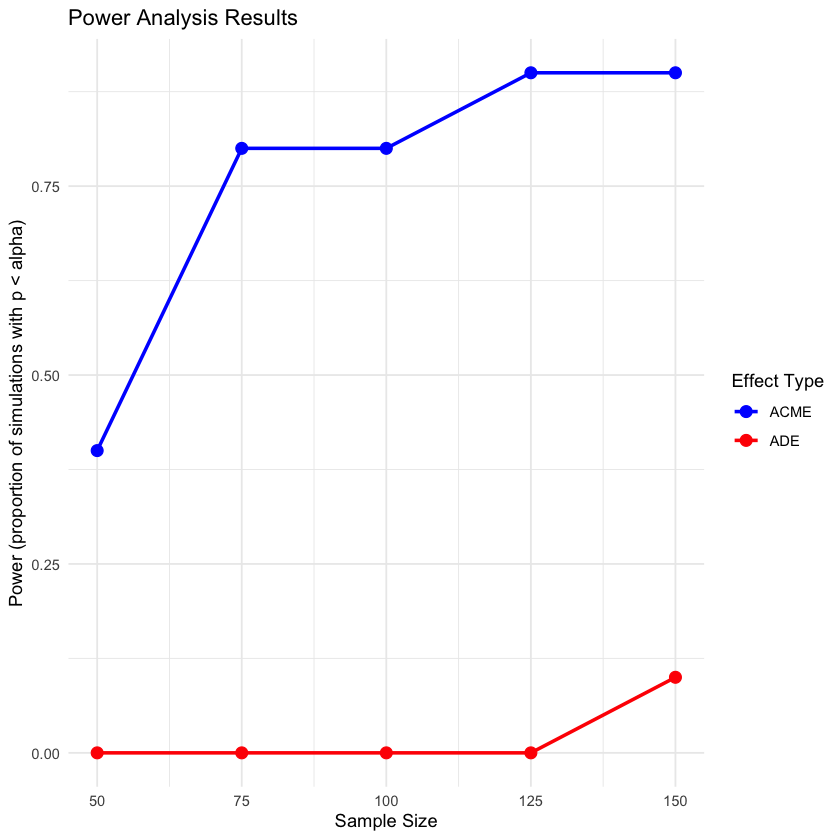

In [ ]:
# Print the final results
print(results)
# create a summary plot of the coverage results
library(ggplot2)
ggplot(results, aes(x = sample_size)) +
    geom_line(aes(y = ACME_cov, color = "ACME"), size = 1) +
    geom_line(aes(y = ADE_cov, color = "ADE"), size = 1) +
    geom_point(aes(y = ACME_cov, color = "ACME"), size = 3) +
    geom_point(aes(y = ADE_cov, color = "ADE"), size = 3) +
    labs(title = "Power Analysis Results",
         x = "Sample Size",
         y = "Power (proportion of simulations with p < alpha)",
         color = "Effect Type") +
    theme_minimal() +
    scale_color_manual(values = c("ACME" = "blue", "ADE" = "red"))


## 5. Reflection (2 pts)

If this were a real power analysis, we'd want to run more simulations per sample size (to get a more precise estimate of power) and we may also want to test out some other values of the parameters we used to simulate our data. However, what would you conclude just based on the results above?

> *ACME represents the mediating or indirect effect, i.e. “Given this model, would I predict that [reading comprehension] would change significantly when I vary [reading experience] but hold [age] constant? The analyses, though with limited sample sizes, gives a strong indication that this is true. ADE answers the opposite question, varying [age] while holding [reading experience] constant. But we get no clear answer here, the experiment isn't set up to answer this question.*
>

**Given** how we generated the data, why was the direct effect harder to detect than the mediated effect?
> *I think the way we generated data, with small sample sizes, made it harder to detect the direct effect. I think, in part, there are many factors that impact reading comprehension so age as a stand-alone is hard to determine, thus adding to the complexity of trying to test for it. For ACME to have 80% power we need at least 100 participants, with 125 or more giving 90% power. But ADE gives only a miniscule bump to 10%, when we're at the highest # of participants tested, which is not sufficient. To get a reasonable power for ADE, you'd need more participants than we tested for. I ran step 3b with 1000 simulations, for instance, and got 0.013 for ADE at an alpha of 0.01. Even that is not close to enough.*

**DUE:** 5pm EST, April 3, 2024

**IMPORTANT** Did you collaborate with anyone on this assignment? If so, list their names here.
> *as per usual, worked with my coding tutor, claude.ai*